In [1]:
import numpy as np
import scipy.interpolate as si
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from skfda.preprocessing.dim_reduction import FPCA
import torch
import torch.nn as nndata
import torch.optim as optim
from models_HLS import *
from data_generation_new import *
from utils import *
from training_HLS import *

In [ ]:
J = 5
d =5000
#sigma = np.repeat(1,J)
sigma = 1.0 / np.arange(1, J + 1)
theta1 = 0.8*np.eye(J)
X_coef, F_basis, fd_basis = generate_fma1_coef(J = J, d = d, Sigma = sigma, Theta = theta1, seed = 10)
print(X_coef.shape)

norms of the basis are: [1. 1. 1. 1. 1.]
(5000, 5)


# Compute the true Long run covariance matrix on the Fourier Basis

In [3]:
center_dat_tensor = torch.tensor(X_coef, dtype=torch.float32)
center_dat_tensor.shape

torch.Size([5000, 5])

In [4]:
print("gamma(-1) = ",gamma_l(center_dat_tensor,-1))
print("gamma(0) = ",gamma_l(center_dat_tensor,0))
print("gamma(1) = ",gamma_l(center_dat_tensor,1))
print("gamma(1)+ gamma(0) +gamma(-1) = ",gamma_l(center_dat_tensor,-1) + gamma_l(center_dat_tensor,0) + gamma_l(center_dat_tensor,1))
print("gamma(-2) = ", gamma_l(center_dat_tensor,-2))

gamma(-1) =  tensor([[ 8.0949e-01,  1.8245e-02, -1.7321e-02,  3.9128e-03, -3.2793e-03],
        [-1.7482e-02,  1.9949e-01,  3.9975e-04, -1.4566e-03, -2.9876e-03],
        [ 2.2837e-03,  5.4490e-03,  9.4305e-02, -1.8610e-03,  2.0261e-03],
        [-4.6357e-03, -4.8735e-03,  2.8603e-03,  5.0764e-02, -2.5796e-03],
        [-2.7179e-03, -1.8311e-03,  4.7560e-03, -2.2444e-03,  3.2217e-02]])
gamma(0) =  tensor([[ 1.6599e+00,  5.0173e-03, -9.0465e-03, -4.7624e-03, -3.6584e-03],
        [ 5.0173e-03,  4.0522e-01,  3.7551e-03, -6.0911e-03, -6.9780e-04],
        [-9.0465e-03,  3.7551e-03,  1.8483e-01,  1.2708e-03,  3.1103e-03],
        [-4.7624e-03, -6.0911e-03,  1.2708e-03,  1.0568e-01, -3.1855e-03],
        [-3.6584e-03, -6.9780e-04,  3.1103e-03, -3.1855e-03,  6.3693e-02]])
gamma(1) =  tensor([[ 8.0949e-01, -1.7482e-02,  2.2837e-03, -4.6357e-03, -2.7179e-03],
        [ 1.8245e-02,  1.9949e-01,  5.4490e-03, -4.8735e-03, -1.8311e-03],
        [-1.7321e-02,  3.9975e-04,  9.4305e-02,  2.8603e-03, 

In [5]:
cov_weighted_true,_,_ =cov_l(center_dat_tensor , 0, round(d**(1/3)),  "Bartlett")
print((cov_weighted_true * 100).round() / 100)
sum(np.diag(cov_weighted_true))

tensor([[ 3.5000,  0.0300, -0.1100,  0.0000, -0.0200],
        [ 0.0300,  0.8600,  0.0200, -0.0100, -0.0100],
        [-0.1100,  0.0200,  0.3600,  0.0000,  0.0100],
        [ 0.0000, -0.0100,  0.0000,  0.2100, -0.0200],
        [-0.0200, -0.0100,  0.0100, -0.0200,  0.1300]])


np.float32(5.057879)

# Conduct FPCA

In [6]:
# Conduct FPCA
fpca_fbasis = FPCA(n_components=3)
fpca_fbasis.fit(fd_basis)
scores = fpca_fbasis.transform(fd_basis)

# Explained variance ratio
print("Explained variance by each PC:", fpca_fbasis.explained_variance_ratio_)
print(sum(fpca_fbasis.explained_variance_ratio_))

Explained variance by each PC: [0.68618356 0.16756389 0.0763404 ]
0.9300878448027794


/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: divide by zero encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: overflow encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:231: RuntimeWarning: invalid value encountered in matmul
  final_matrix = X.coefficients @ np.transpose(l_inv_j_t)
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: divide by zero encountered in matmul
  X.coefficients @ self._j_matrix
/opt/anaconda3/envs/alex_env/lib/python3.10/site-packages/skfda/preprocessing/dim_reduction/_fpca.py:281: RuntimeWarning: overflow encountered in matmul
  X.coeffi

In [7]:
E_coef = fpca_fbasis.components_.coefficients 
print(E_coef)
E_coef.shape

[[ 0.99996549  0.00402228 -0.00617166 -0.00308025 -0.00229417]
 [-0.0039798   0.99963669  0.01735723 -0.02016297 -0.00168021]
 [ 0.00634365 -0.01696285  0.99938743  0.01597482  0.02532972]]


(3, 5)

In [8]:
# Compute the integral of each basis function over [0,1]
def basis_integral(j):
    """Compute the integral of the j-th basis function over [0,1]."""
    return quad(lambda s: F_basis(s)[j], 0, 1)[0]

I_j = np.array([basis_integral(j) for j in range(J)])

# Define beta coefficients (random or fixed values)
beta = np.random.randn(J)

# Compute Y
noise = np.random.normal(0, 1, size=d)
Y_np = np.sum(X_coef * beta * I_j, axis=1) + noise

In [9]:
Y_np.shape

(5000,)

In [10]:
scores.shape

(5000, 3)

In [11]:
center_dat = scores
#center_dat = scores.T - np.mean(scores.T, axis=1, keepdims=True)
center_dat.shape

(5000, 3)

In [12]:
df = pd.DataFrame(center_dat)
df.to_csv("center_dat_fspline.csv", index=False, header=False)

In [13]:
X = torch.tensor(center_dat, dtype=torch.float32) 
print(X.size())
Y = torch.tensor(Y_np, dtype=torch.float32).view(d, 1)
print(Y.size())

torch.Size([5000, 3])
torch.Size([5000, 1])


# Model adding covariates

In [14]:
# Parameters
porder = 0
band = round(d**(1/3)) # the bandwidth
print(band)


17


In [15]:
cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
cov_weighted

tensor([[ 3.4997,  0.0144, -0.0917],
        [ 0.0144,  0.8570,  0.0104],
        [-0.0917,  0.0104,  0.3543]])

In [16]:
cov_weighted_np = cov_weighted.detach().numpy()
cov_weighted_transform = E_coef.T @ cov_weighted_np @ E_coef
print("The estimated LR covariance matrix is:")
print(np.round(cov_weighted_transform,4))
print("The trace of the estimated LR covariance matrix is:")
print(sum(np.diag(cov_weighted_transform)))
print("The true LR covariance matrix is:")
print(np.round(cov_weighted_true.detach().numpy(),4))
print("The trace of the true LR covariance matrix is:")
print(sum(np.diag(cov_weighted_true)))

The estimated LR covariance matrix is:
[[ 3.4982e+00  2.6700e-02 -1.1090e-01 -1.2400e-02 -1.0300e-02]
 [ 2.6700e-02  8.5630e-01  1.8700e-02 -1.7300e-02 -1.4000e-03]
 [-1.1090e-01  1.8700e-02  3.5580e-01  5.5000e-03  9.2000e-03]
 [-1.2400e-02 -1.7300e-02  5.5000e-03  5.0000e-04  2.0000e-04]
 [-1.0300e-02 -1.4000e-03  9.2000e-03  2.0000e-04  3.0000e-04]]
The trace of the estimated LR covariance matrix is:
4.7109452188014975
The true LR covariance matrix is:
[[ 3.4987e+00  2.6400e-02 -1.0980e-01  3.5000e-03 -2.0000e-02]
 [ 2.6400e-02  8.5720e-01  1.7600e-02 -6.5000e-03 -1.1000e-02]
 [-1.0980e-01  1.7600e-02  3.5810e-01  2.5000e-03  7.9000e-03]
 [ 3.5000e-03 -6.5000e-03  2.5000e-03  2.1390e-01 -2.3100e-02]
 [-2.0000e-02 -1.1000e-02  7.9000e-03 -2.3100e-02  1.2990e-01]]
The trace of the true LR covariance matrix is:
5.057879


Epoch [200/5000], Loss: 0.0582
Epoch [400/5000], Loss: 0.0003
Stopping early at Epoch [445/5000], Loss: 0.000100

Restoring best model weights...


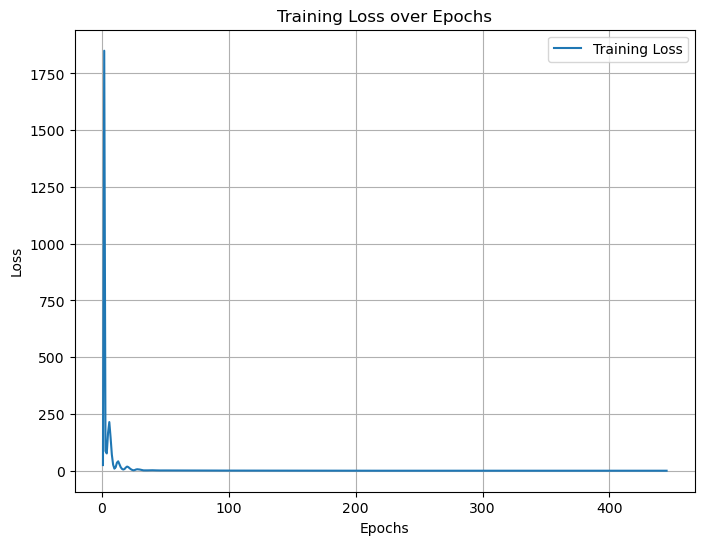

In [17]:
trained_model, losses, best_cov = train_model(
    X=X, Y=Y,
    ModelClass=Model1_new,
    porder=porder,
    band=band,
    kern_type= "Bartlett",
    hidden_dim=64,
    lr=0.01,
    epochs=5000,
    patience=300
)


Shape of Covariance Matrix (NumPy): (3, 3)


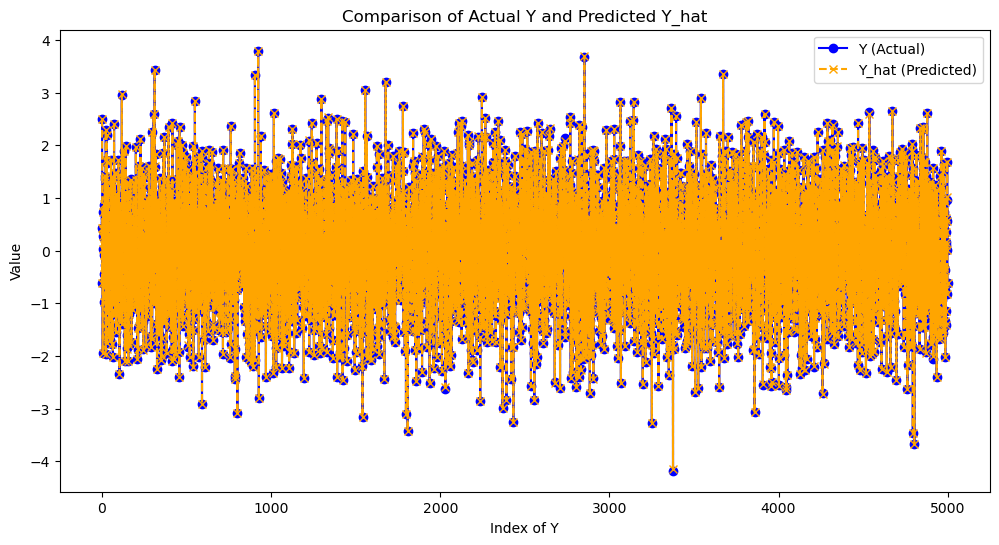

In [18]:
# Compute the best covariance matrix and predictions using the best model
with torch.no_grad():
    cov_weighted, cov_unweighted, cov_triple =cov_l(X, porder, band, kern_type = "Bartlett")
    cov_weighted_np = cov_weighted.cpu().numpy()  # Convert to NumPy

    # Print shape of the covariance matrix
    print("\nShape of Covariance Matrix (NumPy):", cov_weighted_np.shape)

    Y_hat = trained_model(X).view(-1).detach()  # Ensure Y_hat is flattened to match (d,)
    Y_actual = Y.view(-1).detach()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(len(Y_actual)), Y_actual.cpu(), label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(len(Y_hat)), Y_hat.cpu(), label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')

plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()


# Compute true covariance matrix

In [19]:
theoretical_cov_true = np.diag([3.24] * J) @ np.diag(sigma**2)

print(theoretical_cov_true)

[[3.24   0.     0.     0.     0.    ]
 [0.     0.81   0.     0.     0.    ]
 [0.     0.     0.36   0.     0.    ]
 [0.     0.     0.     0.2025 0.    ]
 [0.     0.     0.     0.     0.1296]]


In [20]:
print("Sum of diagonal (theoratical cov matrix):",np.trace(theoretical_cov_true))
print("Sum of diagonal (true cov matrix from data):", np.trace(cov_weighted_true))
print("Sum of diagonal (estimated cov matrix from kernel sandwich method):",np.trace(cov_weighted))
print("Sum of diagonal (estimated cov matrix with all weights =1):",np.trace(cov_unweighted))
print("Sum of diagonal (gamma(-1) + gamma(0)+ gamma(-1)):",np.trace(cov_triple))

Sum of diagonal (theoratical cov matrix): 4.742100000000001
Sum of diagonal (true cov matrix from data): 5.057879
Sum of diagonal (estimated cov matrix from kernel sandwich method): 4.710945
Sum of diagonal (estimated cov matrix with all weights =1): 5.254507
Sum of diagonal (gamma(-1) + gamma(0)+ gamma(-1)): 4.4565897


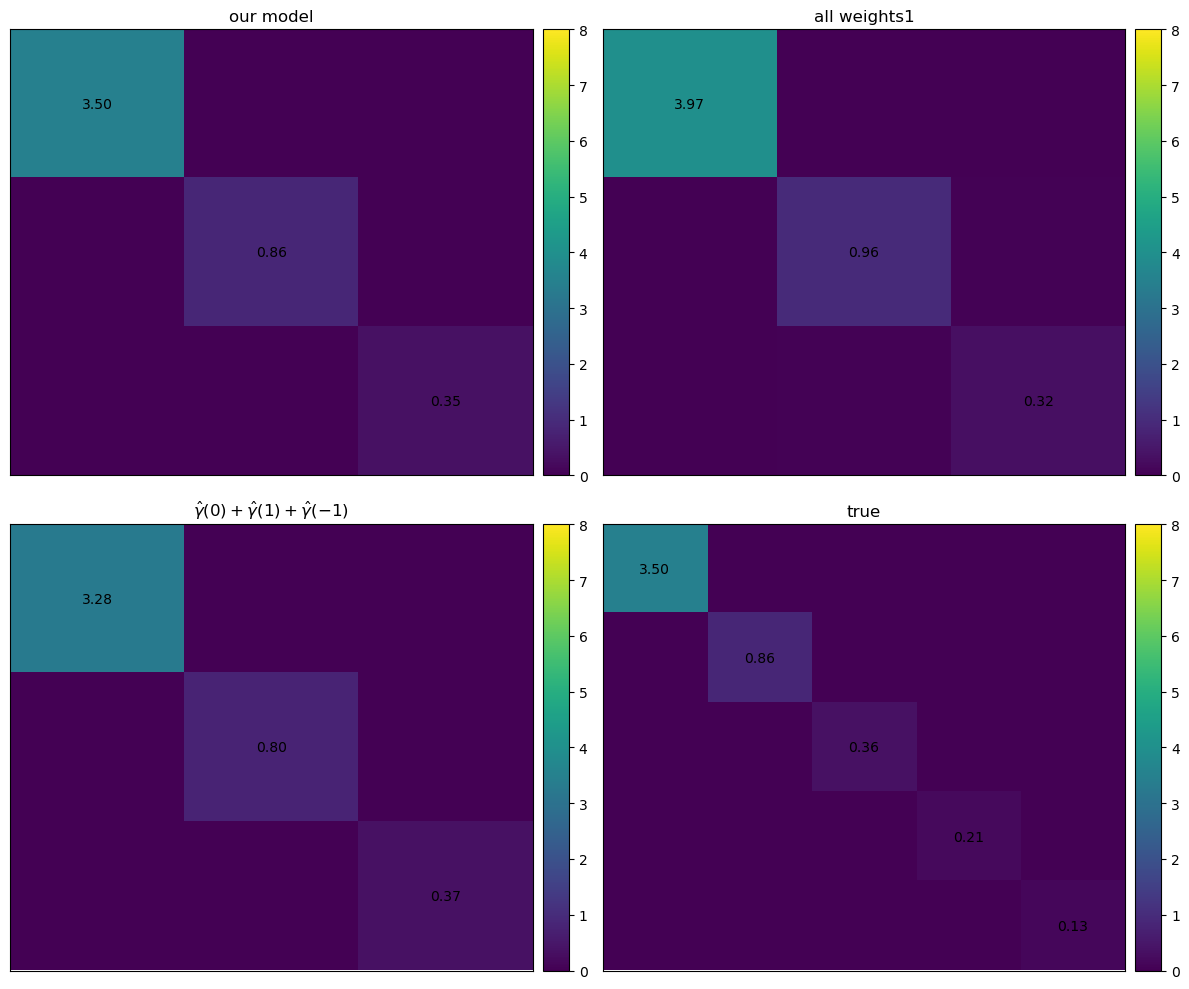

In [21]:
fig = plot_matrices_2d([cov_weighted,cov_unweighted, cov_triple, cov_weighted_true], titles = ["our model", "all weights1", r"$\hat{\gamma}(0) + \hat{\gamma}(1) + \hat{\gamma}(-1)$", "true"])

In [22]:
filename = f"figures/matrix3d_compare{d}_bd{round(band)}.png"
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free memory

print(f"Plot saved as {filename}")

Plot saved as figures/matrix3d_compare5000_bd17.png
